In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sbn 

import statsmodels.api as sm
from patsy import dmatrices

import os 

In [2]:
batch_res = pd.read_csv('./output/batch_effect_results.csv')
batch_res.head()

,batch,pc1_coef,pc1_pval,pc2_coef,pc2_pval,run_id
0,H210514_SET1,0.045484,0.145593,0.081081,0.059126,81726eb7-61e6-49e5-adc9-70dcdf7c29d6
1,H210514_SET2,0.038921,0.211447,0.024591,0.559251,81726eb7-61e6-49e5-adc9-70dcdf7c29d6
2,H210521_SET1,-0.006031,0.845039,0.025711,0.541589,81726eb7-61e6-49e5-adc9-70dcdf7c29d6
3,H210521_SET2,0.018650,0.546350,-0.013055,0.756197,81726eb7-61e6-49e5-adc9-70dcdf7c29d6
4,H210528_SET1,0.024474,0.429337,-0.007595,0.856606,81726eb7-61e6-49e5-adc9-70dcdf7c29d6


In [3]:
run_res = pd.read_csv('./output/experiment_run_results.csv')
run_res.head()

,accuracy(train),pc1_var,pc2_var,kmeans_inertia,res_line,sens_line,drug,nclus,resample_sz,load,burnin,run_id,cell_line,drug_check
0,0.857143,0.509909,0.200358,2.842806,T798I,WT,neratinib,10,100,normalized,8,81726eb7-61e6-49e5-adc9-70dcdf7c29d6,EFM192A,NERATINIB
1,0.923077,0.350776,0.262082,3.795650,ND611,WT,trastuzumab,10,100,normalized,8,10697d2a-26a2-4039-8ced-e7731c8a3475,SKBR3,TRASTUZUMAB
2,1.000000,0.604678,0.116400,3.037901,T798I,WT,neratinib,10,100,normalized,8,972e134a-c895-4ab3-abbb-e476fc6b8e3a,SKBR3,NERATINIB
3,1.000000,0.439913,0.183952,2.902367,ND611,WT,trastuzumab,10,100,normalized,8,f2f3aba1-d808-470e-9bf2-8ca69bc5e245,EFM192A,TRASTUZUMAB


In [4]:
mut_res = pd.read_csv('./output/mutant_resistance_results.csv')
mut_res.head()

,pc1,pc2,treatment,mutant,batch,prob_res,prob_sens,call,run_id,cell_line,drug_check
0,0.391113,0.132393,neratinib,A1160V,H210820,0.080768,0.919232,sens,81726eb7-61e6-49e5-adc9-70dcdf7c29d6,EFM192A,NERATINIB
1,0.088132,-0.221455,neratinib,A355QFS76,H210827_SET1,0.856325,0.143675,res,81726eb7-61e6-49e5-adc9-70dcdf7c29d6,EFM192A,NERATINIB
2,0.102254,-0.059112,neratinib,A37T,H210827_SET2,0.591542,0.408458,res,81726eb7-61e6-49e5-adc9-70dcdf7c29d6,EFM192A,NERATINIB
3,0.184235,-0.152835,neratinib,D639E,H210827_SET1,0.890888,0.109112,res,81726eb7-61e6-49e5-adc9-70dcdf7c29d6,EFM192A,NERATINIB
4,0.138022,-0.170660,neratinib,G778P780DUP,H210820,0.894013,0.105987,res,81726eb7-61e6-49e5-adc9-70dcdf7c29d6,EFM192A,NERATINIB


# Train accuracy 

This is a good metric of how easily sepearable the classes are.

In [5]:
y, X = dmatrices('accuracy ~ nclus + resample_sz + load + burnin', data=run_res.rename({'accuracy(train)':'accuracy'}, axis=1), return_type='dataframe')
mod = sm.OLS(y, X) 
fit = mod.fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:               accuracy   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 08 Jan 2022   Prob (F-statistic):                nan
Time:                        15:01:31   Log-Likelihood:                 5.5989
No. Observations:                   4   AIC:                            -9.198
Df Residuals:                       3   BIC:                            -9.812
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    9.297e-05   3.39e-06     27.425      

/home/teddy/miniconda3/envs/lc_reporter/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


# Batch Effects 

In [6]:
batch_res2 = batch_res.assign(PC1_flag = lambda x: x.pc1_pval < 0.05,
                               PC2_flag = lambda x: x.pc2_pval < 0.05)

batch_res2 = batch_res2.assign(any_flag=lambda x: (x.PC1_flag | x.PC2_flag))

x = mut_res[['cell_line', 'treatment', 'run_id']].drop_duplicates()

batch_res2 = batch_res2.merge(x, on='run_id', how='left')

batch_sum = batch_res2[['batch', 'treatment', 'PC1_flag', "PC2_flag", 'any_flag']].groupby(['batch', 'treatment']).mean().reset_index()
batch_sum.head()

,batch,treatment,PC1_flag,PC2_flag,any_flag
0,H210205_SET1_2,neratinib,0.0,0.0,0.0
1,H210205_SET1_2,trastuzumab,0.0,0.0,0.0
2,H210205_SET2_2,neratinib,0.0,0.0,0.0
3,H210205_SET2_2,trastuzumab,0.0,0.0,0.0
4,H210212_SET1,neratinib,0.0,0.0,0.0


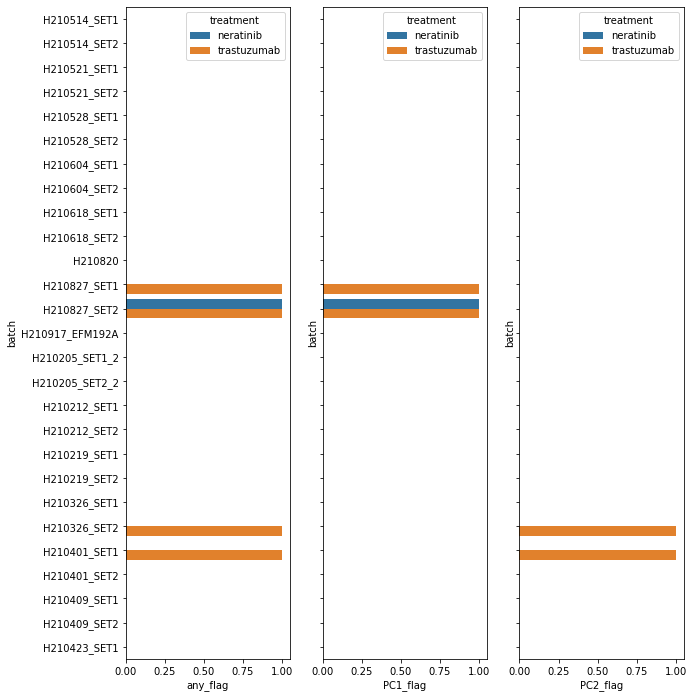

In [7]:
f, axes = plt.subplots(1,3, figsize=(10,12), sharey=True)
sbn.barplot(y='batch', x='any_flag', hue='treatment', data=batch_res2, ax=axes[0])
sbn.barplot(y='batch', x='PC1_flag', hue='treatment', data=batch_res2, ax=axes[1])
sbn.barplot(y='batch', x='PC2_flag', hue='treatment', data=batch_res2, ax=axes[2])
plt.show()

In [10]:
batch_res.batch.unique()

array(['batch[T.H210514_SET2]', 'batch[T.H210521_SET1]',
       'batch[T.H210521_SET2]', 'batch[T.H210528_SET1]',
       'batch[T.H210528_SET2]', 'batch[T.H210604_SET1]',
       'batch[T.H210604_SET2]', 'batch[T.H210618_SET1]',
       'batch[T.H210618_SET2]', 'batch[T.H210820]',
       'batch[T.H210827_SET1]', 'batch[T.H210827_SET2]',
       'batch[T.H210917_EFM192A]', 'batch[T.H210205_SET2_2]',
       'batch[T.H210212_SET1]', 'batch[T.H210212_SET2]',
       'batch[T.H210219_SET1]', 'batch[T.H210219_SET2]',
       'batch[T.H210326_SET1]', 'batch[T.H210326_SET2]',
       'batch[T.H210401_SET1]', 'batch[T.H210401_SET2]',
       'batch[T.H210409_SET1]', 'batch[T.H210409_SET2]',
       'batch[T.H210423_SET1]'], dtype=object)

In [11]:
# BUG: Why don't we have ['H210514_SET1', 'H210205_SET1_2'] in the batch_effects csv ??? 

In [12]:
mut_res2 = mut_res.merge(batch_sum, on=['batch', 'treatment'], how='left')
mut_res2.head()

,pc1,pc2,treatment,mutant,batch,prob_res,prob_sens,call,run_id,cell_line,drug_check,PC1_flag,PC2_flag,any_flag
0,0.399148,0.105805,neratinib,A1160V,H210820,0.070135,0.929865,sens,810e5a2f-42b6-43c4-a281-9fa5ef5dbf97,EFM192A,NERATINIB,0.0,1.0,1.0
1,0.081019,-0.198992,neratinib,A355QFS76,H210827_SET1,0.916043,0.083957,res,810e5a2f-42b6-43c4-a281-9fa5ef5dbf97,EFM192A,NERATINIB,0.0,1.0,1.0
2,0.091566,-0.055524,neratinib,A37T,H210827_SET2,0.567364,0.432636,res,810e5a2f-42b6-43c4-a281-9fa5ef5dbf97,EFM192A,NERATINIB,0.0,0.0,0.0
3,0.178451,-0.134733,neratinib,D639E,H210827_SET1,0.898748,0.101252,res,810e5a2f-42b6-43c4-a281-9fa5ef5dbf97,EFM192A,NERATINIB,0.0,1.0,1.0
4,0.126526,-0.203509,neratinib,G778P780DUP,H210820,0.913677,0.086323,res,810e5a2f-42b6-43c4-a281-9fa5ef5dbf97,EFM192A,NERATINIB,0.0,1.0,1.0


In [13]:
mut_res2[lambda x: x.PC1_flag.isna()].batch.unique()

array(['H210514_SET1', 'H210205_SET1_2'], dtype=object)

In [14]:
mut_res.groupby('batch')['mutant'].count()

batch
H210205_SET1_2     20
H210205_SET2_2     20
H210212_SET1       18
H210212_SET2       20
H210219_SET1       18
H210219_SET2       20
H210326_SET1       20
H210326_SET2       20
H210401_SET1       18
H210401_SET2       18
H210409_SET1       20
H210409_SET2       20
H210423_SET1       20
H210514_SET1       20
H210514_SET2       20
H210521_SET1       20
H210521_SET2       20
H210528_SET1       18
H210528_SET2       16
H210604_SET1       20
H210604_SET2       20
H210618_SET1       20
H210618_SET2       20
H210820            14
H210827_SET1       20
H210827_SET2       20
H210917_EFM192A    20
Name: mutant, dtype: int64

In [110]:
mut_res.shape

(520, 11)

In [111]:
mut_res2.shape

(520, 14)

In [20]:
norm = lambda x, y: (x-min(y))/ (max(y) - min(y)) 

nclus_ = {row.run_id:[0., 1- norm(row.nclus,run_res.nclus),0., 0.5] for i,row in run_res.iterrows()}
nclus_colors = run_res['run_id'].map(nclus_).rename('nclus')

load_ = {row.run_id:'k' if (row.load == 'normalized') else 'w' for i,row in run_res.iterrows()}
load_colors = run_res['run_id'].map(load_).rename('load')

resamp_ = {row.run_id:[1 - norm(row.resample_sz,run_res.resample_sz), 0., 0., 0.5] for i,row in run_res.iterrows()}
resamp_colors = run_res['run_id'].map(resamp_).rename('resample_sz')

row_colors = pd.concat([nclus_colors, load_colors, resamp_colors], axis=1)
row_colors = row_colors.set_index(run_res.run_id)

#print(row_colors)

#ids_tokeep = run_res[lambda x: (x.nclus < 35)].run_id.values
#prob_res2 = prob_res[lambda x: x.run_id.isin(ids_tokeep)]

prob_res2 = mut_res.merge(run_res, on='run_id').pivot(columns='run_id', index='obs_id', values='prob_res')
res_mat = prob_res2.corr().fillna(0)
sbn.clustermap(res_mat, vmin=-1, vmax=1, center=0, row_colors=row_colors, figsize=(10,10))

KeyError: 'obs_id'

# concordant calls

In [15]:
conc_calls = prob_res.groupby(['obs_id', 'call']).count()[['run_id']].reset_index().set_index('obs_id').pivot(columns='call', values='run_id').assign(prop_call_res=lambda x: x.res / (x.res + x.sens))

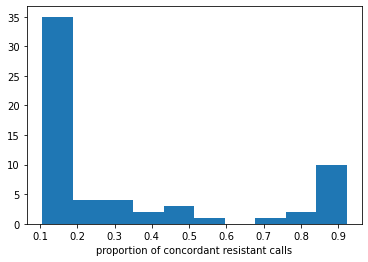

In [70]:
plt.figure()
plt.hist(conc_calls.prop_call_res)
plt.xlabel('proportion of concordant resistant calls')
plt.show()

In [17]:
np.sum( conc_calls.prop_call_res > 0.75 )

12

In [18]:
conc_res_obs_ids = conc_calls[conc_calls.prop_call_res > 0.75].reset_index().obs_id

In [19]:
prob_res[lambda x: x.obs_id.isin(conc_res_obs_ids)].cell_line.unique()

array(['G778S779insLPS', 'L755T759DEL', 'R456C', 'R678Q', 'T798I',
       'V842I', 'Y835F'], dtype=object)

# Model variance 

Same config params, same results? 

In [59]:
def get_model_variance_stats(nclus, load, sz): 
    
    _ids = run_res[lambda x: (x.nclus==nclus) & (x.load == load) & (x.resample_sz == sz)].run_id
    mvar_ = prob_res[lambda x: x.run_id.isin(_ids)]
    mvar_res = mvar_[['run_id', 'obs_id', 'prob_res']].pivot(columns='run_id', values='prob_res', index='obs_id')
    mvar_mat = mvar_res.corr()

    triu_idx = np.triu_indices(mvar_mat.shape[0], k=1)
    corrs = mvar_mat.values[triu_idx]
    corr_mean = corrs.mean()
    corr_std = corrs.std()
    corr_min = corrs.min()
    corr_max = corrs.max()
    return corr_mean, corr_std, corr_min, corr_max

var_res = {'nclus':[], 'load':[], 'resample_sz':[], 'corr_mean':[], 'corr_std':[], 'corr_min':[], 'corr_max':[]}
for nc in run_res.nclus.unique(): 
    for l in run_res.load.unique(): 
        for sz in run_res.resample_sz.unique(): 
            corr_mean, corr_std, corr_min, corr_max = get_model_variance_stats(nc, l, sz)
            var_res['nclus'].append(nc)
            var_res['load'].append(l)
            var_res['resample_sz'].append(sz)
            var_res['corr_mean'].append(corr_mean)
            var_res['corr_std'].append(corr_std)
            var_res['corr_min'].append(corr_min)
            var_res['corr_max'].append(corr_max)
            
var_res = pd.DataFrame(var_res).assign(corr_min_unit = lambda x: x.corr_min.clip(0,1))
var_res.head()

,nclus,load,resample_sz,corr_mean,corr_std,corr_min,corr_max,corr_min_unit
0,15,raw,75,0.935192,0.020712,0.905259,0.972514,0.905259
1,15,raw,150,0.938284,0.016595,0.902949,0.969040,0.902949
2,15,raw,125,0.949348,0.019311,0.919606,0.982665,0.919606
3,15,raw,50,0.908513,0.033114,0.834107,0.959517,0.834107
4,15,raw,100,0.938958,0.017862,0.906228,0.966396,0.906228


In [60]:
lm = logit('corr_min_unit ~ nclus + resample_sz + load', data=var_res).fit() #Specify C for Categorical
print(lm.params)
print()
print(lm.conf_int())
#print()
#print(sm.stats.anova_lm(lm))

Optimization terminated successfully.
         Current function value: 0.197250
         Iterations 7
Intercept      4.222236
load[T.raw]   -0.420407
nclus         -0.162454
resample_sz    0.002738
dtype: float64

                    0         1
Intercept    1.429946  7.014527
load[T.raw] -1.919332  1.078518
nclus       -0.229108 -0.095800
resample_sz -0.018269  0.023746


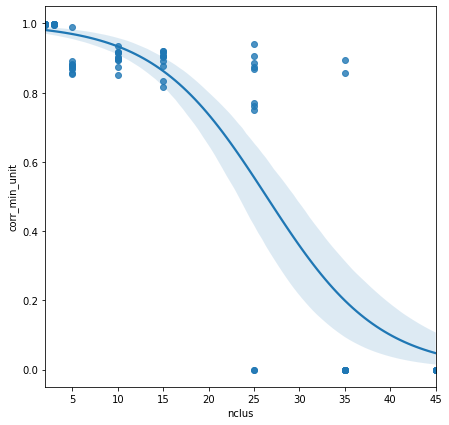

In [61]:
plt.figure(figsize=(7,7))
sbn.regplot(x='nclus', y='corr_min_unit', data=var_res, logistic=True)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

No handles with labels found to put in legend.


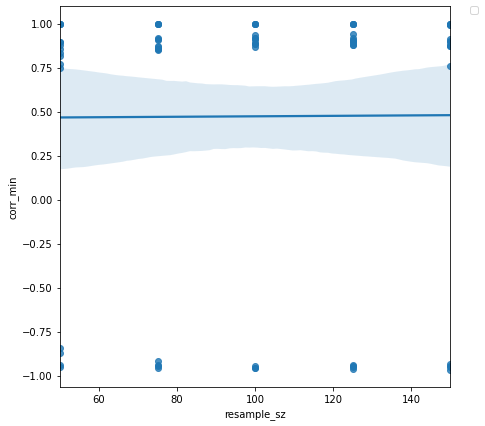

In [54]:
plt.figure(figsize=(7,7))
sbn.regplot(x='resample_sz', y='corr_min', data=var_res, logistic=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

No handles with labels found to put in legend.


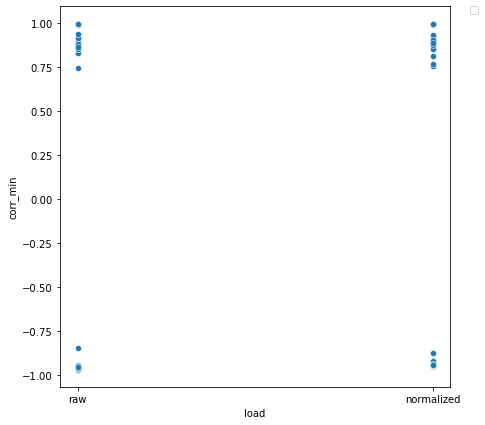

In [41]:
plt.figure(figsize=(7,7))
sbn.scatterplot(x='load', y='corr_min', data=var_res)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Stable Configs


In [71]:
var_res.head()

,nclus,load,resample_sz,corr_mean,corr_std,corr_min,corr_max,corr_min_unit
0,15,raw,75,0.935192,0.020712,0.905259,0.972514,0.905259
1,15,raw,150,0.938284,0.016595,0.902949,0.969040,0.902949
2,15,raw,125,0.949348,0.019311,0.919606,0.982665,0.919606
3,15,raw,50,0.908513,0.033114,0.834107,0.959517,0.834107
4,15,raw,100,0.938958,0.017862,0.906228,0.966396,0.906228


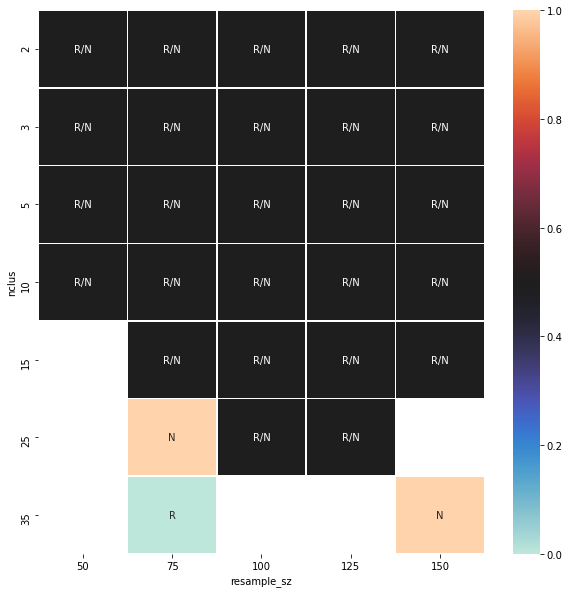

In [113]:
var_res2 = var_res[lambda x: x.corr_min > 0.85][['resample_sz', 'nclus', 'load']].groupby(['resample_sz', 'nclus']).agg('-'.join).reset_index()
var_mat = var_res2.assign(load= [0 if x=='raw' else (1 if x=='normalized' else 0.5) for x in var_res2.load])
labels = var_res2.assign(load= ['R' if x=='raw' else ('N' if x=='normalized' else 'R/N') for x in var_res2.load]).pivot(columns='resample_sz', index='nclus', values='load')
var_mat = var_mat.pivot(columns='resample_sz', index='nclus', values='load')

plt.figure(figsize=(10,10))
sbn.heatmap(var_mat, linewidths=.5, annot=labels.values, fmt='', vmin=0, vmax=1, center=0.5)
plt.show()

In [139]:
acc_mat

load
resample_sz nclus      
50          2       1.0
            3       1.0
            10      1.0
75          2       1.0
            3       0.5
            10      1.0
            15      1.0
100         2       1.0
            3       1.0
            10      1.0
125         2       1.0
            3       0.5
            10      1.0
            15      1.0
150         2       1.0
            3       0.5
            10      1.0
            15      1.0

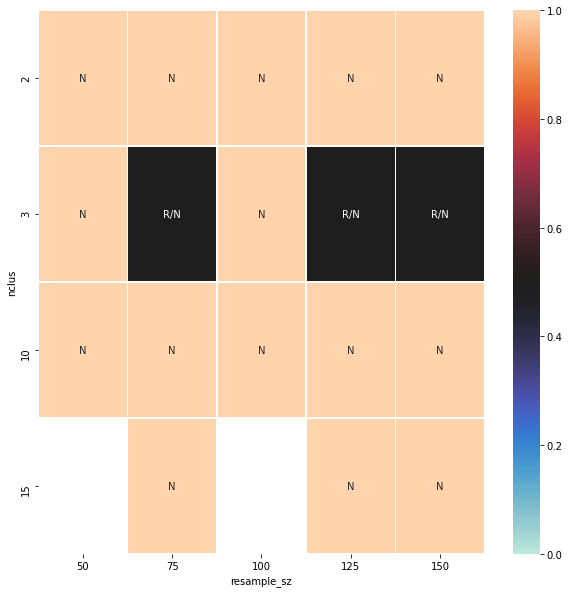

In [142]:
hi_ac = run_res.groupby(['nclus', 'resample_sz', 'load']).agg('mean')[['accuracy(train)']][lambda x: x['accuracy(train)'] == 1.]

hi_ac = hi_ac.reset_index()[['nclus', 'resample_sz', 'load']].groupby(['resample_sz', 'nclus']).agg('-'.join).reset_index()

acc_mat = hi_ac.assign(load= [0 if x=='raw' else (1 if x=='normalized' else 0.5) for x in hi_ac.load]).pivot(columns='resample_sz', index='nclus', values='load')
labels = hi_ac.assign(load= ['R' if x=='raw' else ('N' if x=='normalized' else 'R/N') for x in hi_ac.load]).pivot(columns='resample_sz', index='nclus', values='load')

plt.figure(figsize=(10,10))
sbn.heatmap(acc_mat, linewidths=.5, annot=labels.values, fmt='', vmin=0, vmax=1, center=0.5)
plt.show()

In [121]:


plt.figure(figsize=(10,10))
sbn.heatmap(var_mat, linewidths=.5, annot=labels.values, fmt='', vmin=0, vmax=1, center=0.5)
plt.show()

accuracy(train)
nclus resample_sz load                       
2     50          normalized              1.0
      75          normalized              1.0
      100         normalized              1.0
      125         normalized              1.0
      150         normalized              1.0
3     50          normalized              1.0
      75          normalized              1.0
                  raw                     1.0
      100         normalized              1.0
      125         normalized              1.0
                  raw                     1.0
      150         normalized              1.0
                  raw                     1.0
10    50          normalized              1.0
      75          normalized              1.0
      100         normalized              1.0
      125         normalized              1.0
      150         normalized              1.0
15    75          normalized              1.0
      125         normalized              1.0
      150         normalized              1.0